In [1]:
#Fetch Data 
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import pandas as pd
import time
import requests
import re



In [2]:
#Approach 1 :Add logical seperation based on simple  First Name and last Name pattern as observed manually.
class TranscriptParser:
    def __init__(self, url):
        self.url = url
        self.soup = None
        self.blocks = []
        self.rawtext=None

    def fetch(self):
        headers = {
            "User-Agent": "Mozilla/5.0",
            "Referer": "https://www.google.com/"
        }
        response = requests.get(self.url, headers=headers)
        self.soup = BeautifulSoup(response.text, "html.parser")

    def parse_blocks(self):
        self.raw_text = self.soup.get_text(separator="\n")
        self.raw_text = self.raw_text.replace("\\n:", ":").replace("\n:", ":")
        lines = self.raw_text.split("\n")
        current_speaker = None
        current_block = []
        
        for line in lines:
            line = line.strip()
            if not line:
                continue

            # Detect speaker change
            match = re.search(r"^(.*?)(, CEO|, CFO|, Director of Investor Relations).*?:", line)
            if match:
                if current_speaker and current_block:
                    self.blocks.append({
                        "speaker": current_speaker,
                        "text": "\n".join(current_block)
                    })
                current_speaker = match.group(1)
                current_block = [line]
            else:
                current_block.append(line)

        # Add final block
        if current_speaker and current_block:
            self.blocks.append({
                "speaker": current_speaker,
                "text": "\n".join(current_block)
            })

    def get_blocks(self):
        return self.blocks


In [3]:
trans=TranscriptParser('https://www.investing.com/news/transcripts/earnings-call-transcript-apple-beats-q3-2025-forecasts-stock-dips-93CH-4164767')
trans.fetch()
trans.parse_blocks()
blocks=trans.blocks
print(f"{blocks[0]}")

{'speaker': 'Suhasini Chandramali', 'text': 'Suhasini Chandramali, Director of Investor Relations, Apple:  Good afternoon, and welcome to the Apple q fiscal year twenty twenty five earnings conference call. My name is Suhasini Chandramali, Director of Investor Relations. Today’s call is being recorded. Speaking first today is Apple’s CEO, Tim Cook, and he’ll be followed by CFO, Kevin Parekh. After that, we’ll open the call to questions from analysts.\nPlease note that some of the information you’ll hear during our discussion today will consist of forward looking statements, including, without limitation, those regarding revenue, gross margin, operating expenses, other income and expense, taxes, capital allocation and future business outlook. These statements involve risks and uncertainties that may cause actual results or trends to differ materially from our forecast, including risks related to the potential impact to the company’s business and results of operations from macroeconomic 

In [4]:
for b in blocks:
    print(f"{b}")

{'speaker': 'Suhasini Chandramali', 'text': 'Suhasini Chandramali, Director of Investor Relations, Apple:  Good afternoon, and welcome to the Apple q fiscal year twenty twenty five earnings conference call. My name is Suhasini Chandramali, Director of Investor Relations. Today’s call is being recorded. Speaking first today is Apple’s CEO, Tim Cook, and he’ll be followed by CFO, Kevin Parekh. After that, we’ll open the call to questions from analysts.\nPlease note that some of the information you’ll hear during our discussion today will consist of forward looking statements, including, without limitation, those regarding revenue, gross margin, operating expenses, other income and expense, taxes, capital allocation and future business outlook. These statements involve risks and uncertainties that may cause actual results or trends to differ materially from our forecast, including risks related to the potential impact to the company’s business and results of operations from macroeconomic 

In [5]:
#Semantic chuncking applied to data broken down per user .
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai import OpenAIEmbeddings
from typing import List

def getSemanticChunks(text: str,breakpoint_threshold_amount=.75) -> List[str]:
    embeddings = OpenAIEmbeddings()
    splitter = SemanticChunker(
        embeddings,
        add_start_index=True,
        breakpoint_threshold_type="percentile",
        breakpoint_threshold_amount=breakpoint_threshold_amount
    )
    chunks = splitter.split_text(text)
    return chunks


In [6]:
len(blocks)

42

In [7]:
#Vector store to store and read from redis
import redis
import numpy as np
import openai
from redis.commands.search.field import TextField, TagField, VectorField
from redis.commands.search.index_definition  import IndexDefinition, IndexType
from pydantic import BaseModel,field_validator
from typing import Optional
class Document(BaseModel):
    id:str
    content:str
    chunk_id:Optional[int]=0
    score:Optional[int]=0
    doc_name:str
    year:int
    embedding:Optional[np.ndarray]=None
    speaker:Optional[str]=None
    @field_validator("embedding", mode="before")
    def normalize_embedding(cls, v):
        if isinstance(v, (bytes, bytearray, memoryview)):
            return np.frombuffer(v, dtype=np.float32)
        elif isinstance(v, list):
            return np.array(v, dtype=np.float32)
        elif isinstance(v, np.ndarray):
            return v.astype(np.float32)
        raise TypeError(f"Unsupported embedding format: {type(v)}")
    model_config = {
        "arbitrary_types_allowed": True
    }

class LexicalDocument(BaseModel):
    id:str
    content:str
    doc_name:str
    year:int
class LexicalDocuments(BaseModel):
     documents:list[LexicalDocument]
     id:str
     idf_score:str
     model_config = {
        "arbitrary_types_allowed": True
    }
         
    


class VectorStore:
    def __init__(self, host: str = "host.docker.internal", port: int = 6379):
        self.r = redis.Redis(host=host, port=port, decode_responses=False)

    def embed(self, text: str) -> np.ndarray:
        response = openai.embeddings.create(
            model="text-embedding-ada-002",
            input=text
        )
        return np.array(response.data[0].embedding, dtype=np.float32)
    def storeLexicalData(self, store:LexicalDocuments):
        docs=store.documents

        for doc in docs:
                    self.r.hset(doc.id, mapping={
                    "content": doc.content,
                    "year": doc.year,
                    "doc_name": doc.doc_name
                
                })
        self.r.hset(store.id,mapping={"idf_score":store.idf_score})
    def retriveLexicalData(self, contentKey: str, idfscoreKey: str) -> LexicalDocuments:
        docs: list[LexicalDocument] = []

        for key in self.r.scan_iter(contentKey):
            raw_fields = self.r.hgetall(key)
            fields = {k.decode("utf-8"): v.decode("utf-8") for k, v in raw_fields.items()}
            if "year" in fields:
                fields["year"] = int(fields["year"])
            fields["id"]=key
            doc = LexicalDocument(**fields)
            docs.append(doc)

        raw_idf_fields = self.r.hgetall(idfscoreKey)
        idf_fields = {k.decode("utf-8"): v.decode("utf-8") for k, v in raw_idf_fields.items()}

        lexical_bundle = {
            "documents": docs,
            "id": idf_fields.get("id", idfscoreKey),
            "idf_score": idf_fields.get("content", "{}")
        }

        return LexicalDocuments(**lexical_bundle)


         


    def store(self, docs: list[Document]):
        for doc in docs:
            embedding = self.embed(doc.content).tobytes()
            if doc.speaker is None:
                    self.r.hset(doc.id, mapping={
                    "content": doc.content,
                    "year": doc.year,
                    "embedding": embedding,
                    "doc_name": doc.doc_name,
                    "chunk_id": doc.chunk_id
                
                })
            else:
                self.r.hset(doc.id, mapping={
                    "content": doc.content,
                    "year": doc.year,
                    "embedding": embedding,
                    "doc_name": doc.doc_name,
                    "chunk_id": doc.chunk_id,
                    "speaker":doc.speaker
                })
            
    def retrieve(self, doc_id: str) -> Document:
        raw_fields = self.r.hgetall(doc_id)
        fields = {k.decode(): v.decode() for k, v in raw_fields.items() if k != b'embedding'}
        if len(fields)==0:
            return None
        if "chunk_id" in fields:
            fields["chunk_id"] = int(fields["chunk_id"])
        if "year" in fields:
            fields["year"] = int(fields["year"])
        if "score" in fields:
            fields["score"] = int(fields["score"])
        
        fields["id"] = doc_id
        


        raw_embedding = self.r.hget(doc_id, "embedding")
        if raw_embedding is None and "lexical" not in doc_id:
            print(f"{raw_fields} raw feilds")
            raise ValueError(f"Missing 'embedding' for doc_id: {doc_id}")

        fields["embedding"] = np.frombuffer(raw_embedding, dtype=np.float32)
        return Document(**fields)


In [8]:
#Semantic chuncking applied to data broken down per user .
#text = "\n".join([f"{b['speaker']}: {b['text']}" for b in blocks])
vs = VectorStore()
i=0

for b in blocks:
    ls =list[Document]()    
    for c in getSemanticChunks(b['text'].replace("\n",""),.95):
        d={}
        d["id"]=f"transcript_{i}"
        d["content"]=c
        d["year"]=2025
        d["doc_name"]="apple transcript call Q3 2025"
        d["chunk_id"]=i
        d["speaker"]=b['speaker']
        ls.append(Document(**d))
        i+=1
    vs.store(ls)

In [9]:
raw_text = trans.soup.get_text(separator="\n")
lines = raw_text.split("\n")       
for line in lines:
    line = line.strip()
    if not line:
        continue
text2=".".join(lines)
chunks2= getSemanticChunks(text2,.95)
print(len(chunks2))

456


In [10]:
#Save chunks with different indexes
vs = VectorStore()
ls_call=list[Document]()
for i,c in enumerate(chunks2):
    d={}
    d["id"]=f"call_{i}"
    d["content"]=c
    d["year"]=2025
    d["doc_name"]="apple transcript call Q3 2025"
    d["chunk_id"]=i
    ls_call.append(Document(**d))
vs.store(ls_call)

In [11]:
vs = VectorStore()
raw1=vs.retrieve("transcript_1")
raw=vs.retrieve("call_1")
print(raw1)
print(raw)

id='transcript_1' content='Today’s call is being recorded.' chunk_id=1 score=0 doc_name='apple transcript call Q3 2025' year=2025 embedding=array([-0.0191801 , -0.00879142, -0.00034367, ..., -0.0086605 ,
       -0.02318632, -0.00974061], shape=(1536,), dtype=float32) speaker='Suhasini Chandramali'
id='call_1' content='30Y.U.S.' chunk_id=1 score=0 doc_name='apple transcript call Q3 2025' year=2025 embedding=array([-0.00502491, -0.03152473,  0.00768283, ...,  0.00966635,
       -0.00078804, -0.01441357], shape=(1536,), dtype=float32) speaker=None


In [12]:
queries = [
    #Performance & Financials
    "How did Apple’s iPhone segment perform in Q3?",
    "What were the key drivers of revenue growth?",
    "Did Apple mention any challenges in the wearables category?",
    "What was the gross margin and how did it change?",
    #Strategic Direction
    "What is Apple’s stance on AI integration?",
    "Did Tim Cook mention future product innovations?",
    "How is Apple positioning itself in emerging markets?",
    #Speaker Attribution & Sentiment
    "What did Tim Cook say about macroeconomic conditions?",
    "Was the CFO optimistic about Q4?",
    "Which statements reflect caution or uncertainty?"
]
embedings=[]

In [13]:
# Compare query and get similar chunks
from redis.commands.search.query import Query
import numpy as np
import time
class StoredDocument(BaseModel):
    content:Optional[str]=None
    doc_name:Optional[str]=None
    id:str
    score:float
    year:Optional[int]=0
    embedding:Optional[np.ndarray]=None
    others:Optional[dict]=None
    @field_validator("embedding", mode="before")
    def normalize_embedding(cls, v):
        if isinstance(v, (bytes, bytearray, memoryview)):
            return np.frombuffer(v, dtype=np.float32)
        elif isinstance(v, list):
            return np.array(v, dtype=np.float32)
        elif isinstance(v, np.ndarray):
            return v.astype(np.float32)
        raise TypeError(f"Unsupported embedding format: {type(v)}")
    model_config = {
        "arbitrary_types_allowed": True
    }
    


class RedisQueryRunner:
    def __init__(self, vs:VectorStore, index_a="transcript_idx", index_b="call_idx"):
        self.vs = vs
        self.store=vs.r
    
        self.index_a = index_a
        self.index_b = index_b
        
    def lexicalSearch(self,queryStr,index='idf_lexical_idx'):
        q = Query(queryStr) \
                .sort_by("idf_score", asc=False) \
                .return_fields("content", "doc_name","idf_score", "id") \
                .paging(0, 10)
        start = time.time()
        res =  self.store.ft(index).search(q)
        latency = time.time() - start
        results=[doc for doc in res.docs]
        return results,latency

    def search(self,index, top_k,query_vec,queryStr=None):
            if queryStr is None:
                queryStr=f"*=>[KNN {top_k} @embedding $vec AS score]"
            q = Query(queryStr) \
                .return_fields("content", "doc_name", "chunk_id", "score", "id", "embedding") \
                .sort_by("score", asc=False) \
                .dialect(2)

            start = time.time()
            res =  self.store.ft(index).search(q, query_params={"vec": query_vec})
            latency = time.time() - start

            results = []
            for doc in res.docs:
                raw_embedding = doc.embedding
                try:
                    if isinstance(raw_embedding, memoryview):
                        raw_embedding = bytes(raw_embedding)
                    elif isinstance(raw_embedding, str):
                        raw_embedding = raw_embedding.encode('latin1')
                    elif not isinstance(raw_embedding, (bytes, bytearray)):
                        raise TypeError(f"Unexpected embedding type: {type(raw_embedding)}")

                    doc.embedding = np.frombuffer(raw_embedding, dtype=np.float32)

                except Exception as e:
                    #print(f"Failed to decode embedding for doc {doc.id} from search: {e}")
                    try:
                        fallback_raw = vs.retrieve(doc.id)
                        doc.embedding = fallback_raw.embedding
                        #print(f"Recovered embedding for doc {doc.id} via fallback")
                    except Exception as fallback_error:
                        #print(f"Fallback failed for doc {doc.id}: {fallback_error}")
                        doc.embedding = None

                results.append(doc)

            return results, latency

    def run_query(self, query_text,query_vec_emb:np.array, top_ka=10,top_kb=10):
        query_vec = query_vec_emb.astype(np.float32).tobytes()      
        results_a, latency_a = self.search(self.index_a,top_ka,query_vec)
        results_b, latency_b = self.search(self.index_b,top_kb,query_vec)

        return {
            "query": query_text,
            self.index_a: {
                "results": results_a,
                "latency_ms": latency_a
            },
            self.index_b: {
                "results": results_b,
                "latency_ms": latency_b
            }
        }


In [14]:
q_embeddings=[]
for q in queries :
    query_vec = vs.embed(q)
    q_embeddings.append(query_vec)


In [15]:
idx=['transcript_idx','call_idx']
rQRunner=RedisQueryRunner(vs,idx[0],idx[1])
results=[]
for i,q in enumerate(queries) :
   result=rQRunner.run_query(q,q_embeddings[i])
   results.append(result)
   print(f"\nQuery: {result['query']}")
   print(f"{idx[0]} latency: {result[idx[0]]['latency_ms']:.2f} ms")
   print(f"{idx[1]} latency: {result[idx[1]]['latency_ms']:.2f} ms")


   for i, doc in enumerate(result[idx[0]]['results']):
        print(f"{idx[0]}-{i} Score: {float(doc.score):.4f}, Chunk ID: {doc.chunk_id}")

   for i, doc in enumerate(result[idx[1]]['results']):
        print(f"{idx[1]}-{i} Score: {float(doc.score):.4f}, Chunk ID: {doc.chunk_id}")





Query: How did Apple’s iPhone segment perform in Q3?
transcript_idx latency: 0.02 ms
call_idx latency: 0.01 ms
transcript_idx-0 Score: 0.1472, Chunk ID: 37
transcript_idx-1 Score: 0.1459, Chunk ID: 13
transcript_idx-2 Score: 0.1442, Chunk ID: 14
transcript_idx-3 Score: 0.1438, Chunk ID: 164
transcript_idx-4 Score: 0.1412, Chunk ID: 98
transcript_idx-5 Score: 0.1392, Chunk ID: 184
transcript_idx-6 Score: 0.1384, Chunk ID: 90
transcript_idx-7 Score: 0.1350, Chunk ID: 15
transcript_idx-8 Score: 0.1279, Chunk ID: 38
transcript_idx-9 Score: 0.1240, Chunk ID: 99
call_idx-0 Score: 0.1442, Chunk ID: 46
call_idx-1 Score: 0.1432, Chunk ID: 344
call_idx-2 Score: 0.1412, Chunk ID: 131
call_idx-3 Score: 0.1399, Chunk ID: 19
call_idx-4 Score: 0.1398, Chunk ID: 341
call_idx-5 Score: 0.1384, Chunk ID: 123
call_idx-6 Score: 0.1350, Chunk ID: 47
call_idx-7 Score: 0.1283, Chunk ID: 132
call_idx-8 Score: 0.1279, Chunk ID: 70
call_idx-9 Score: 0.1277, Chunk ID: 20

Query: What were the key drivers of reve

In [16]:
idx=['transcript_idx','call_idx']
rQRunner=RedisQueryRunner(vs,idx[0],idx[1])
results=[]
for i,q in enumerate(queries) :
   result=rQRunner.run_query(q,q_embeddings[i])
   results.append(result)
   print(f"\nQuery: {result['query']}")
   print(f"{idx[0]} latency: {result[idx[0]]['latency_ms']:.2f} ms")
   print(f"{idx[1]} latency: {result[idx[1]]['latency_ms']:.2f} ms")
   for i, doc in enumerate(result[idx[0]]['results']):
        print(f"{idx[0]}-{i} Score: {float(doc.score):.4f}, Chunk ID: {doc.chunk_id}")

   for i, doc in enumerate(result[idx[1]]['results']):
        print(f"{idx[1]}-{i} Score: {float(doc.score):.4f}, Chunk ID: {doc.chunk_id}")


Query: How did Apple’s iPhone segment perform in Q3?
transcript_idx latency: 0.01 ms
call_idx latency: 0.00 ms
transcript_idx-0 Score: 0.1472, Chunk ID: 37
transcript_idx-1 Score: 0.1459, Chunk ID: 13
transcript_idx-2 Score: 0.1442, Chunk ID: 14
transcript_idx-3 Score: 0.1438, Chunk ID: 164
transcript_idx-4 Score: 0.1412, Chunk ID: 98
transcript_idx-5 Score: 0.1392, Chunk ID: 184
transcript_idx-6 Score: 0.1384, Chunk ID: 90
transcript_idx-7 Score: 0.1350, Chunk ID: 15
transcript_idx-8 Score: 0.1279, Chunk ID: 38
transcript_idx-9 Score: 0.1240, Chunk ID: 99
call_idx-0 Score: 0.1442, Chunk ID: 46
call_idx-1 Score: 0.1432, Chunk ID: 344
call_idx-2 Score: 0.1412, Chunk ID: 131
call_idx-3 Score: 0.1399, Chunk ID: 19
call_idx-4 Score: 0.1398, Chunk ID: 341
call_idx-5 Score: 0.1384, Chunk ID: 123
call_idx-6 Score: 0.1350, Chunk ID: 47
call_idx-7 Score: 0.1283, Chunk ID: 132
call_idx-8 Score: 0.1279, Chunk ID: 70
call_idx-9 Score: 0.1277, Chunk ID: 20

Query: What were the key drivers of reve

Looking at score ,transcript_ids has more variation in score hence we can reduce the k  for it .

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

import pandas as pd

class ChunkingComparison:
    def __init__(self):
        self.data = []

    def add_result(self, query, summary, cosine_sim):
        self.data.append({
            'query': query,
            'top_score_transcript': summary['transcript_idx']['top_score'],
            'top_score_call': summary['call_idx']['top_score'],
            'avg_score_transcript': summary['transcript_idx']['avg_top_k_score'],
            'avg_score_call': summary['call_idx']['avg_top_k_score'],
            'avg_chunk_transcript': summary['transcript_idx']['avg_chunk_length'],
            'avg_chunk_call': summary['call_idx']['avg_chunk_length'],
            'total_chunk_transcript': sum(summary['transcript_idx']['chunk_lengths']),
            'total_chunk_call': sum(summary['call_idx']['chunk_lengths']),
            'cosine_similarity': cosine_sim
        })

    def to_dataframe(self):
        return pd.DataFrame(self.data)

class CompareData:
    def summarize_scores_with_chunk_length(self,a, idx):
        summary = {}
        
        for index in idx:
            docs = a[index]['results']
            #print(f"{docs}")
            scores = [float(doc.score) for doc in docs]
            lengths = [len(doc.content) for doc in docs]
            top_k=len(docs)

            summary[index] = {
                "top_score": max(scores),
                "avg_top_k_score": sum(scores) / top_k,
                "avg_chunk_length": sum(lengths) / top_k,
                "chunk_lengths": lengths
            }

        return summary

    def createComparisonData(self,results):
        comparison = ChunkingComparison()
        for result in results:
            summary = self.summarize_scores_with_chunk_length(result, ['transcript_idx', 'call_idx'])
            cos_sim = self.semantic_overlap(result['transcript_idx']['results'], result['call_idx']['results'])
            comparison.add_result(result['query'], summary, cos_sim)

        df_initial = comparison.to_dataframe()
        df_initial['query_id'] = ['Q' + str(i+1) for i in range(len(df_initial))]
        return df_initial

    def decode_embedding(self,blob, dim=1536):
        return np.frombuffer(blob, dtype=np.float32)

    def semantic_overlap(self,chunks_a, chunks_b, dim=1536):
        embeddings_a = [self.decode_embedding(doc.embedding, dim) for doc in chunks_a]
        embeddings_b = [self.decode_embedding(doc.embedding, dim) for doc in chunks_b]
        
    # Stack into 2D arrays for cosine_similarity
        emb_a = np.vstack(embeddings_a)
        emb_b = np.vstack(embeddings_b)

        sim_matrix = cosine_similarity(emb_a, emb_b)
        print(sim_matrix)
        return sim_matrix.mean()


Both strategies produce varying length chunks .K was picked based on total chunk length .We can compare similarty with average chunk size

In [18]:

df_ini=CompareData().createComparisonData(results)



[[0.92316854 0.82050765 0.94633687 0.84359026 0.83687806 0.9206552
  0.8548391  0.8811227  0.8687451  0.87832975]
 [0.88867915 0.81771266 0.87406427 0.835147   0.8230206  0.9117941
  0.9024968  0.8791244  0.9078897  0.8824811 ]
 [1.         0.8287078  0.89103353 0.81696284 0.846272   0.87571764
  0.88624156 0.89127815 0.894662   0.8856035 ]
 [0.82902753 0.813357   0.8138745  0.8286954  0.8203976  0.8321836
  0.83484644 0.8276515  0.8538249  0.84406936]
 [0.8910335  0.8250529  1.0000002  0.8357306  0.8130301  0.93867576
  0.86388975 0.8608747  0.913584   0.9136585 ]
 [0.8630359  0.8040579  0.8475897  0.838207   0.8296599  0.88046354
  0.88347965 0.87237704 0.8641022  0.8590502 ]
 [0.87571764 0.8275722  0.93867576 0.86091083 0.81388974 1.
  0.86711854 0.8525089  0.887674   0.8934996 ]
 [0.88624156 0.830655   0.86388975 0.8123267  0.8196697  0.86711854
  1.0000001  0.92979205 0.887656   0.8703395 ]
 [0.894662   0.8322752  0.91358393 0.8282211  0.8390583  0.887674
  0.887656   0.88593256 1

In [19]:
df_ini["cosine_similarity"]

0    0.872628
1    0.857320
2    0.820706
3    0.841431
4    0.845716
5    0.871058
6    0.841402
7    0.866940
8    0.824621
9    0.779755
Name: cosine_similarity, dtype: float32

In [20]:
import matplotlib.pyplot as plt

class PlotData:
    def __init__(self,df):
        self.df=df
    
    def plot_metric(self,metric_transcript, metric_call, title, ylabel):
        fig, ax = plt.subplots(figsize=(12, 6))
        x = np.arange(len(self.df)) 
        width = 0.35

        ax.bar(x-width/2, self.df[metric_transcript], width, label='Transcript')
        ax.bar(x+width/2, self.df[metric_call], width,label='Call', alpha=0.7)

        for i, query in enumerate(self.df['query']):
            y_max = max(self.df[metric_transcript][i], self.df[metric_call][i])
            ax.text(x[i], y_max + 0.01, f"{query[:30]}", rotation=90, fontsize=8, ha='center')

        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xlabel('Query ID')
        ax.legend()
        plt.tight_layout()
        plt.show()

# Plot each metric
    def build(self):
        self.plot_metric('top_score_transcript', 'top_score_call', 'Top Score Comparison', 'Score')
        self.plot_metric('avg_score_transcript', 'avg_score_call', 'Avg Top-k Score Comparison', 'Score')
        self.plot_metric( 'avg_chunk_transcript', 'avg_chunk_call', 'Avg Chunk Size Comparison', 'Tokens')
        self.plot_metric('total_chunk_transcript', 'total_chunk_call', 'Total Chunk Size Comparison', 'Tokens')

        # Line chart for cosine similarity
        plt.figure(figsize=(10, 8))
        plt.plot([x[:30]for x in self.df['query']], self.df['cosine_similarity'], marker='o', linestyle='-', color='purple')
        plt.xticks(rotation=45, ha='right')
        plt.title('Cosine Similarity Mean for Chunking Strategies')
        plt.xlabel('Query')
        plt.ylabel('Cosine Similarity')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


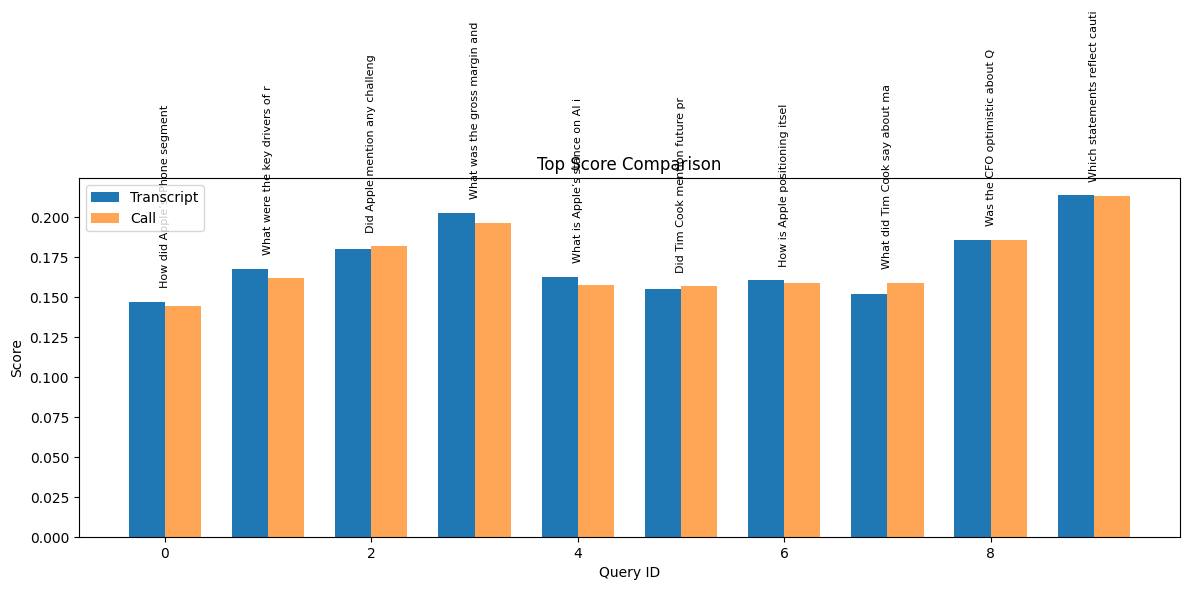

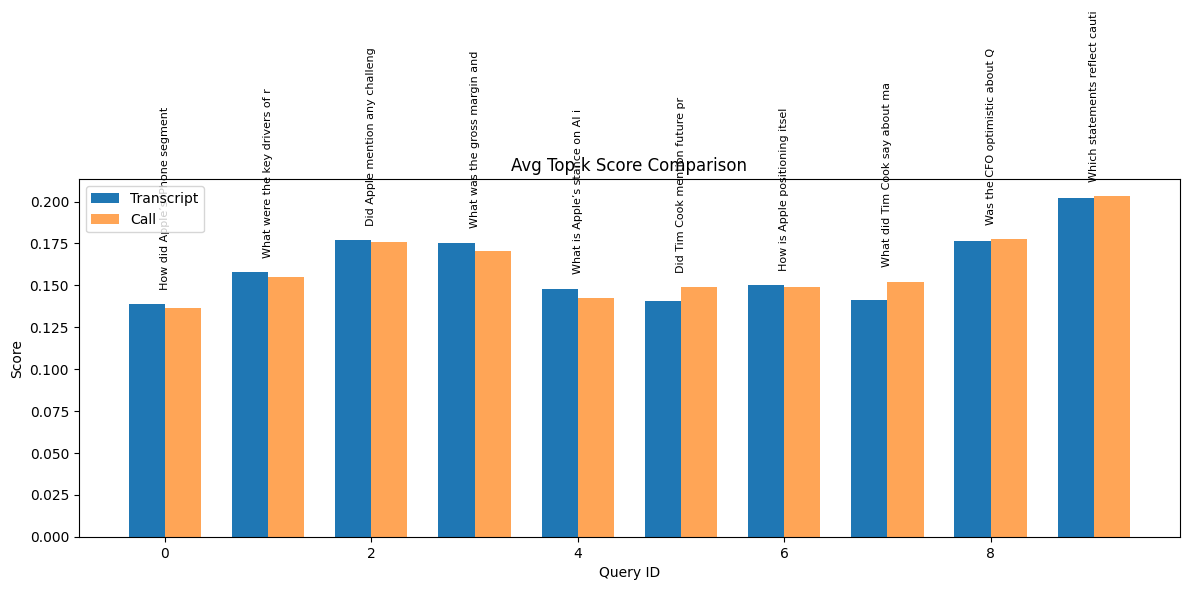

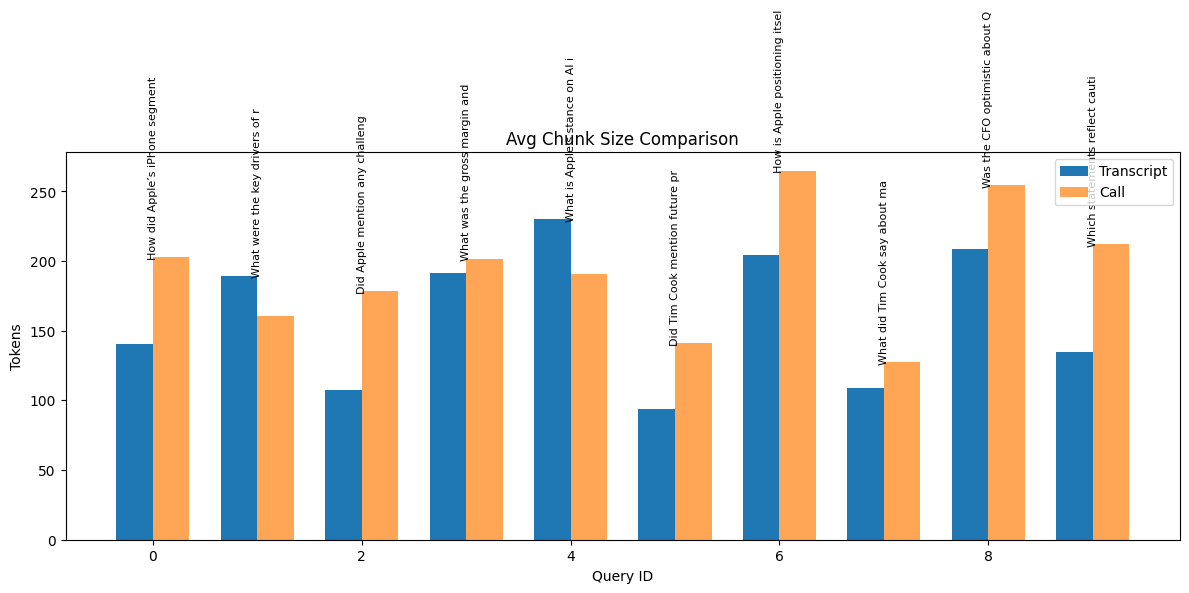

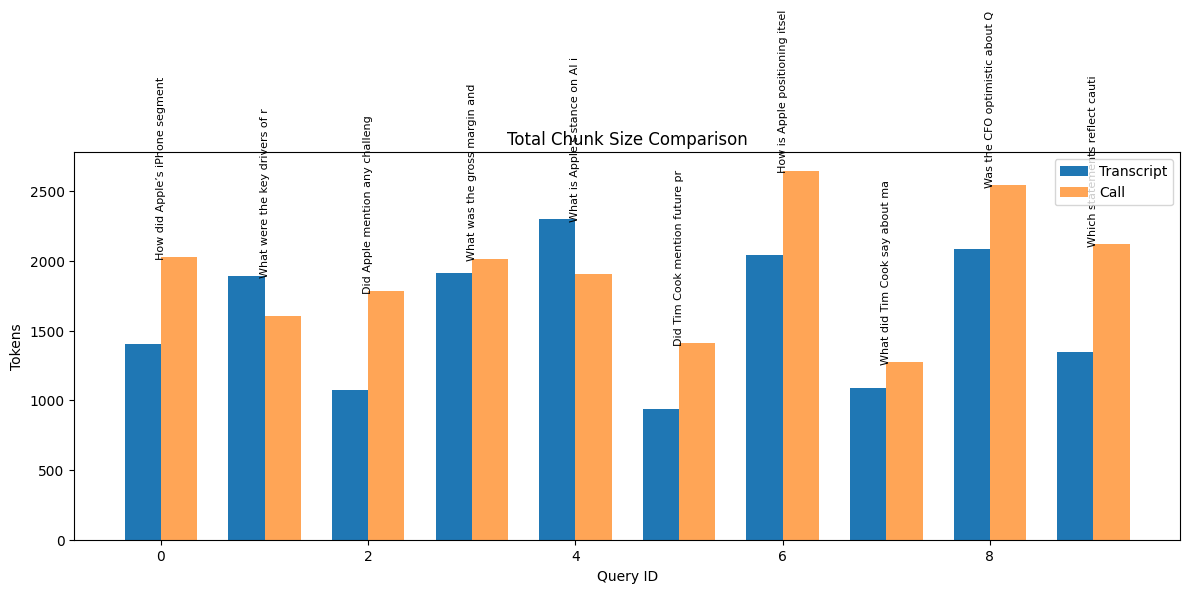

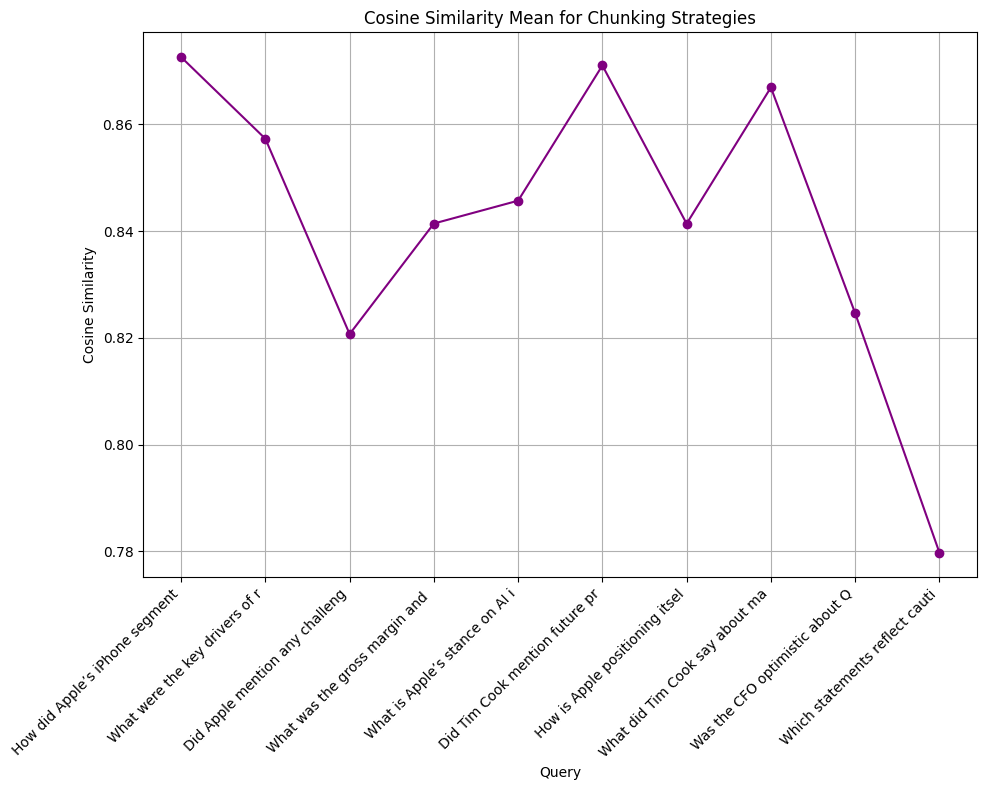

In [21]:
pltData=PlotData(df_ini)
pltData.build()

Ranges are too low -need to impreove from .2 to .5 .We will try different strategy

Transcript was better in all segments but where questions where tied manual preprocessing ( we broke this on users) .Manually evaluating those answers.

In [22]:
print(f'{results[5]["query"]}')
[d.content for d in results[5]["transcript_idx"]["results"]]

Did Tim Cook mention future product innovations?


['I would remind you that we do have a hybrid model though where we also leverage third party infrastructure in addition to investing in our own first party infrastructure.Tim Cook, CEO, Apple3:  Yeah.',
 'Tim Cook, CEO, Apple:  Thank you.',
 'Tim Cook, CEO, Apple:  I the way that we look at AI is that it’s one of the most profound technologies of our lifetime. And I think it will affect all devices in a significant way.',
 'Tim Cook, CEO, Apple:  It was principally on iPhone and Mac.',
 'Yeah.Tim Cook, CEO, Apple3:  Thanks for taking the question.',
 'Tim Cook, CEO, Apple:  Yeah. When you when you think about all the things an iPhone can do from connecting people to bringing app and game experiences to life, to taking photos and videos, to helping users explore the world and conduct their financial lives and pay for things and so much more.',
 'Tim Cook, CEO, Apple:  Yes.',
 'Tim Cook, CEO, Apple:  Yeah.',
 'Tim Cook, CEO, Apple:  Yeah.',
 'Tim Cook, CEO, Apple:  Yeah.']

In [23]:
[d.content for d in results[5]["call_idx"]["results"]]

['And I’m kind of curious to get your thoughts on if do you think that would happen and and rate and pace in which, and and how do you think Apple is preparing in in in that case?...Tim Cook, CEO, Apple.:  Yeah.',
 'Apple’s strategic focus will remain on AI development and integration across its platforms..Executive Commentary.CEO Tim Cook emphasized the importance of AI, stating, "AI is one of the most profound technologies of our lifetime." He highlighted Apple’s commitment to embedding AI across devices and platforms.',
 'Tim, at the WWDC earlier in the quarter, you showed impressive updates on VisionPRO with the use of widgets, facial scenes, persona and new ways to create content.',
 'Yeah....Tim Cook, CEO, Apple.3:  Thanks for taking the question.',
 'Do you feel like you need to accelerate your AI roadmap or just keep the organic focus?...Tim Cook, CEO, Apple.:  Let me take that one as well.',
 'And I have a follow-up....Tim Cook, CEO, Apple.:  It was principally on iPhone and M

In [24]:
[d.content for d in results[7]["transcript_idx"]["results"]]

['Tim Cook, CEO, Apple:  Yeah. Wamsi, I don’t really want to speculate on the court ruling and how they would rule and what we would do as a consequence of it.Wamsi Mohan, Analyst, Bank of America:  Okay.',
 'Tim Cook, CEO, Apple:  We did grow in Greater China by 4% during the quarter versus the previous quarter. It was driven by an acceleration by iPhone, although we also had substantial growth on the Mac year over year.',
 'Tim Cook, CEO, Apple:  You want to do CapEx first?',
 'And so that was the the limited impact that we really we saw for the quarter.Tim Cook, CEO, Apple2:  Got it.',
 'Tim Cook, CEO, Apple:  It was principally on iPhone and Mac.',
 'Tim Cook, CEO, Apple:  I would be careful about projecting based on the numbers from Q2 and Q3 because, one, we’re uncertain of what the rates will be, and so the rates may change. Two, in particularly in last quarter, we had some build ahead inventory that we were that we had within the company and within our supplier within our suppl

In [25]:
[d.content for d in results[7]["call_idx"]["results"]]

['And I’m kind of curious to get your thoughts on if do you think that would happen and and rate and pace in which, and and how do you think Apple is preparing in in in that case?...Tim Cook, CEO, Apple.:  Yeah.',
 'Yeah....Tim Cook, CEO, Apple.3:  Thanks for taking the question.',
 'I think in an interview earlier this afternoon, you alluded to some of the promotions being tailwinds....But just bigger picture, if we take a step back in China, how would you characterize demand interest in the iPhone 16 and some of your other products?',
 'And I have a follow-up....Tim Cook, CEO, Apple.:  Yeah.',
 'And when do you decide to execute on the levers to offset this headwind versus just looking at your bottom line?...Tim Cook, CEO, Apple.:  You know, right now, we’re just estimating the cost of it.',
 'Yes....Tim Cook, CEO, Apple.:  We did grow in Greater China by 4% during the quarter versus the previous quarter.',
 'Thanks....Tim Cook, CEO, Apple.:  Yeah.',
 'Do you feel like you need to ac

In [26]:
context_6_transcript_idx="".join([d.content for d in results[5]["transcript_idx"]["results"]]).replace("\n","")
context_6_call_idx="".join([d.content for d in results[5]["call_idx"]["results"]]).replace("\n","")
context_8_transcript_idx="".join([d.content for d in results[7]["transcript_idx"]["results"]]).replace("\n","")
context_8_call_idx="".join([d.content for d in results[7]["call_idx"]["results"]]).replace("\n","")
question_6=results[5]["query"]
question_8=results[7]["query"]
context_8_transcript_idx

'Tim Cook, CEO, Apple:  Yeah. Wamsi, I don’t really want to speculate on the court ruling and how they would rule and what we would do as a consequence of it.Wamsi Mohan, Analyst, Bank of America:  Okay.Tim Cook, CEO, Apple:  We did grow in Greater China by 4% during the quarter versus the previous quarter. It was driven by an acceleration by iPhone, although we also had substantial growth on the Mac year over year.Tim Cook, CEO, Apple:  You want to do CapEx first?And so that was the the limited impact that we really we saw for the quarter.Tim Cook, CEO, Apple2:  Got it.Tim Cook, CEO, Apple:  It was principally on iPhone and Mac.Tim Cook, CEO, Apple:  I would be careful about projecting based on the numbers from Q2 and Q3 because, one, we’re uncertain of what the rates will be, and so the rates may change. Two, in particularly in last quarter, we had some build ahead inventory that we were that we had within the company and within our supplier within our supply chain.Tim Cook, CEO, App

Manual comparison highlighted the difference in retrived chunks 

In [27]:
results[5][idx[0]]['results']

[Document {'id': 'transcript_376', 'payload': None, 'score': '0.155158340931', 'content': 'I would remind you that we do have a hybrid model though where we also leverage third party infrastructure in addition to investing in our own first party infrastructure.Tim Cook, CEO, Apple3:  Yeah.', 'doc_name': 'apple transcript call Q3 2025', 'chunk_id': '376', 'embedding': array([ 0.00938069, -0.00589241,  0.0155384 , ..., -0.01504054,
        -0.02030735,  0.00160084], shape=(1536,), dtype=float32)},
 Document {'id': 'transcript_248', 'payload': None, 'score': '0.154859960079', 'content': 'Tim Cook, CEO, Apple:  Thank you.', 'doc_name': 'apple transcript call Q3 2025', 'chunk_id': '248', 'embedding': array([-0.01417787, -0.02522475,  0.00967075, ..., -0.015958  ,
        -0.02142463,  0.01280806], shape=(1536,), dtype=float32)},
 Document {'id': 'transcript_327', 'payload': None, 'score': '0.149661302567', 'content': 'Tim Cook, CEO, Apple:  I the way that we look at AI is that it’s one of t

[[0.92316854 0.82050765 0.94633687 0.84359026 0.83687806 0.9206552
  0.8548391  0.8811227  0.8687451  0.87832975]
 [0.88867915 0.81771266 0.87406427 0.835147   0.8230206  0.9117941
  0.9024968  0.8791244  0.9078897  0.8824811 ]
 [1.         0.8287078  0.89103353 0.81696284 0.846272   0.87571764
  0.88624156 0.89127815 0.894662   0.8856035 ]
 [0.82902753 0.813357   0.8138745  0.8286954  0.8203976  0.8321836
  0.83484644 0.8276515  0.8538249  0.84406936]
 [0.8910335  0.8250529  1.0000002  0.8357306  0.8130301  0.93867576
  0.86388975 0.8608747  0.913584   0.9136585 ]
 [0.8630359  0.8040579  0.8475897  0.838207   0.8296599  0.88046354
  0.88347965 0.87237704 0.8641022  0.8590502 ]
 [0.87571764 0.8275722  0.93867576 0.86091083 0.81388974 1.
  0.86711854 0.8525089  0.887674   0.8934996 ]
 [0.88624156 0.830655   0.86388975 0.8123267  0.8196697  0.86711854
  1.0000001  0.92979205 0.887656   0.8703395 ]
 [0.894662   0.8322752  0.91358393 0.8282211  0.8390583  0.887674
  0.887656   0.88593256 1

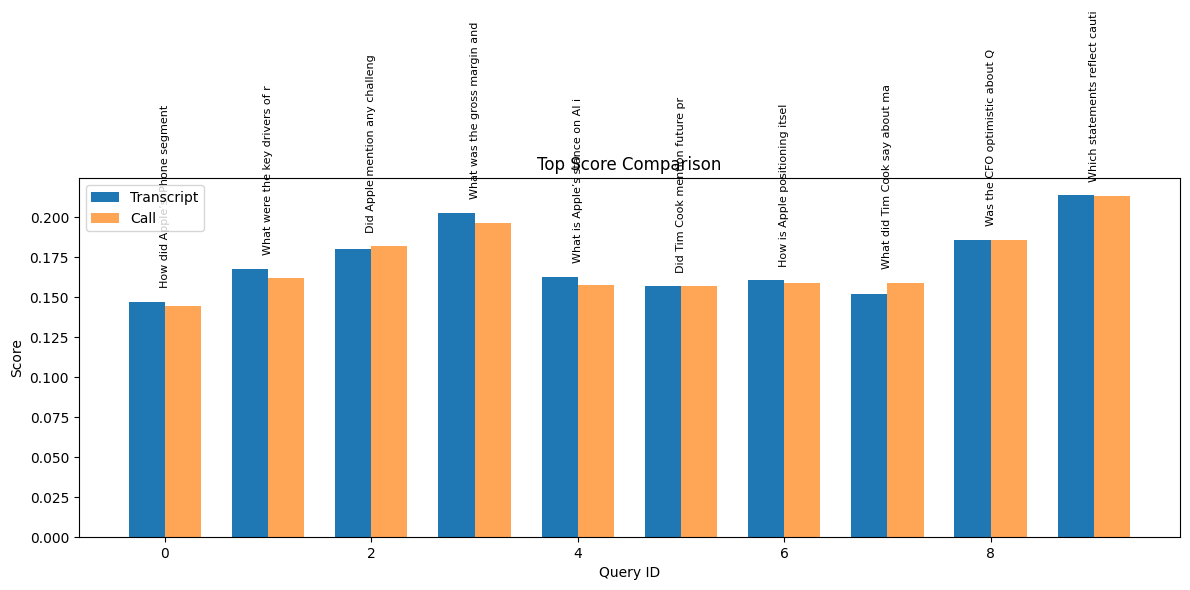

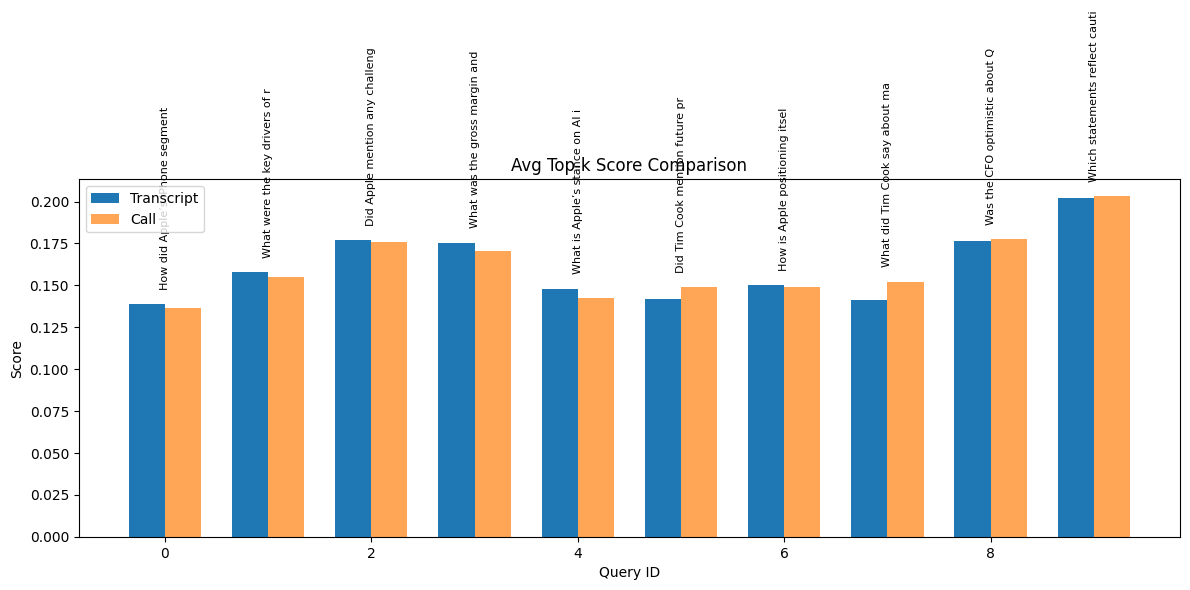

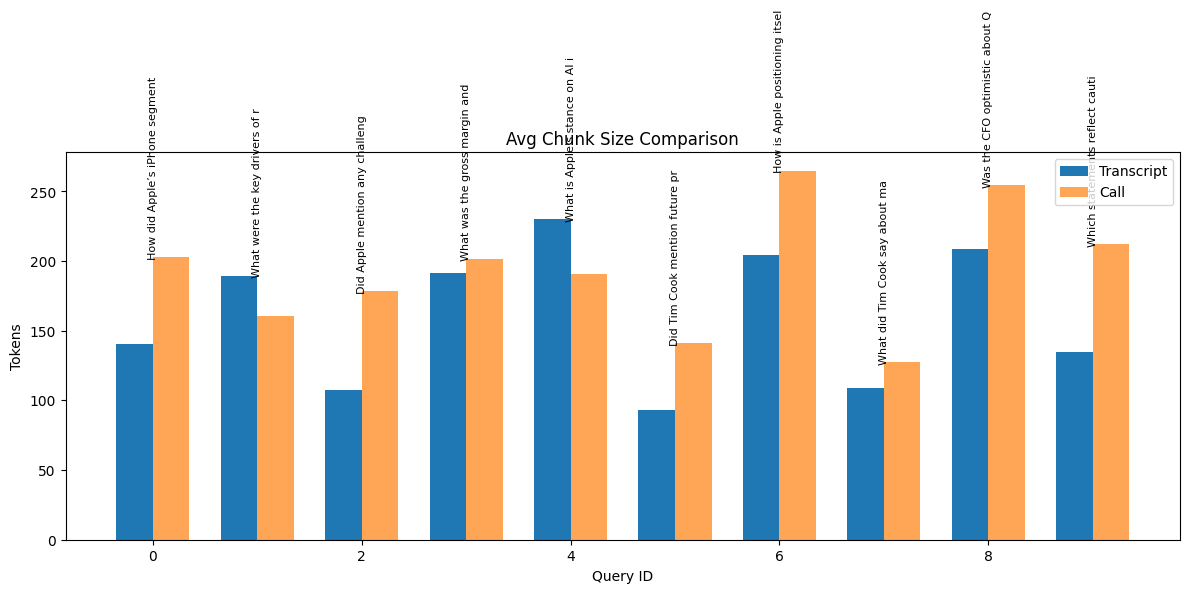

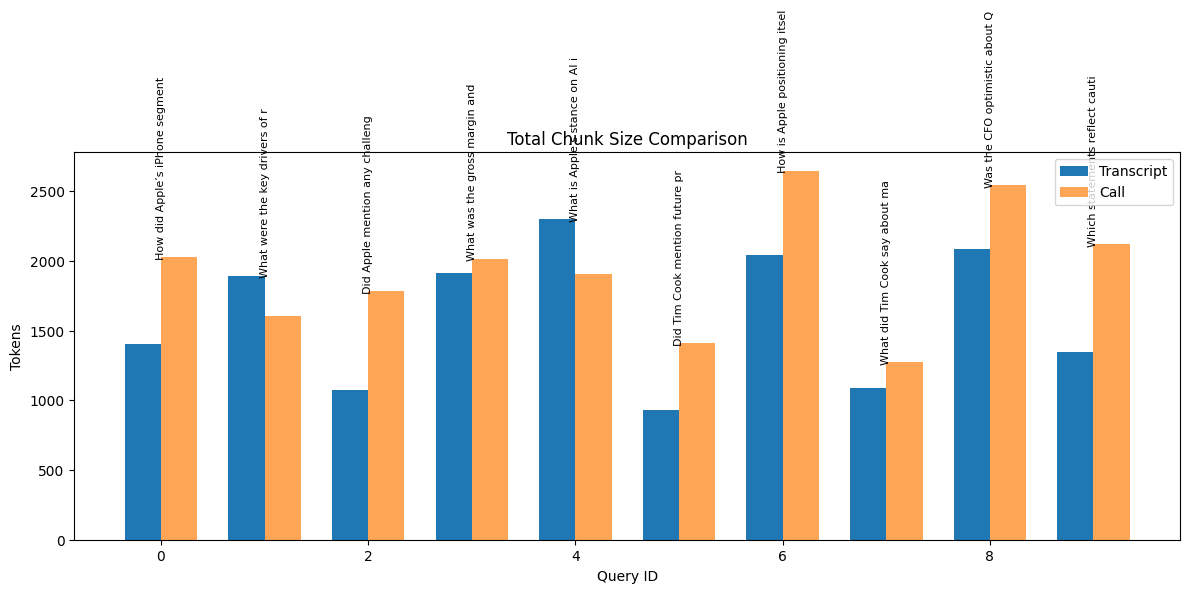

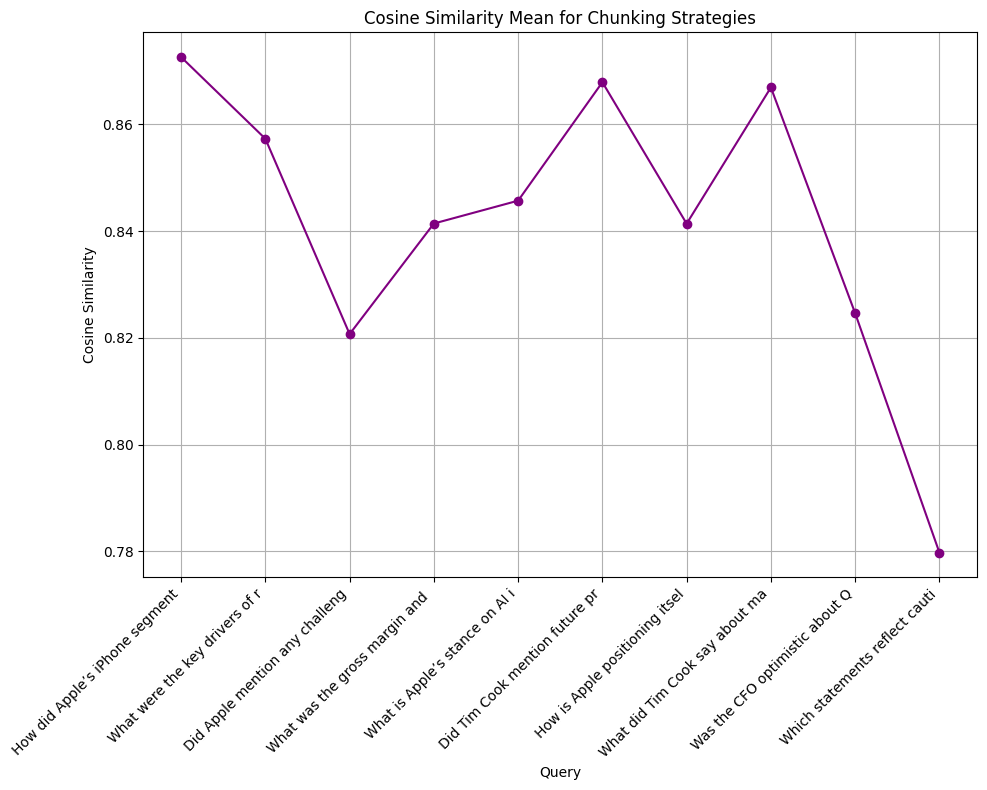

In [28]:
#for i,q in enumerate(queries) :
import copy

new_list = copy.deepcopy(results)
queryStr = f"(@speaker:{{Tim Cook}})=>[KNN {10} @embedding $vec AS score]"
rQRunner=RedisQueryRunner(vs,idx[0],idx[1])
result,latency=rQRunner.search(idx[0],10,q_embeddings[5].astype(np.float32).tobytes(),queryStr)
new_list[5][idx[0]]['results']=result
dfModified =CompareData().createComparisonData(new_list)
pltData=PlotData(dfModified)
pltData.build()

Using speaker Tagfeild did bring small improvement in max K value of QUERY 5

In [29]:
[doc.content for doc in new_list[5][idx[0]]['results']]

['Tim Cook, CEO, Apple:  US now, and we’re we will do more.',
 'Tim Cook, CEO, Apple:  On the upgrades, Michael, if you look at iPhone, the 16 family grew double digit as opposed to the 15 family from the year ago quarter. And so we did set an upgrade record.',
 'Tim Cook, CEO, Apple:  Thank you.',
 'Tim Cook, CEO, Apple:  I the way that we look at AI is that it’s one of the most profound technologies of our lifetime. And I think it will affect all devices in a significant way.',
 'Tim Cook, CEO, Apple:  It was principally on iPhone and Mac.',
 'Tim Cook, CEO, Apple:  Yeah. When you when you think about all the things an iPhone can do from connecting people to bringing app and game experiences to life, to taking photos and videos, to helping users explore the world and conduct their financial lives and pay for things and so much more.',
 'Tim Cook, CEO, Apple:  Yes.',
 'Tim Cook, CEO, Apple:  Yeah.',
 'Tim Cook, CEO, Apple:  Yeah.',
 'Tim Cook, CEO, Apple:  Yeah.']

In [30]:
[doc.content for doc in results[5][idx[0]]['results']]

['I would remind you that we do have a hybrid model though where we also leverage third party infrastructure in addition to investing in our own first party infrastructure.Tim Cook, CEO, Apple3:  Yeah.',
 'Tim Cook, CEO, Apple:  Thank you.',
 'Tim Cook, CEO, Apple:  I the way that we look at AI is that it’s one of the most profound technologies of our lifetime. And I think it will affect all devices in a significant way.',
 'Tim Cook, CEO, Apple:  It was principally on iPhone and Mac.',
 'Yeah.Tim Cook, CEO, Apple3:  Thanks for taking the question.',
 'Tim Cook, CEO, Apple:  Yeah. When you when you think about all the things an iPhone can do from connecting people to bringing app and game experiences to life, to taking photos and videos, to helping users explore the world and conduct their financial lives and pay for things and so much more.',
 'Tim Cook, CEO, Apple:  Yes.',
 'Tim Cook, CEO, Apple:  Yeah.',
 'Tim Cook, CEO, Apple:  Yeah.',
 'Tim Cook, CEO, Apple:  Yeah.']

Using speaker didnt help significantly.Combinig TF_IDF approach and calculate cosine scores .Semantic search retrives documentS to be considered .It can be used to build TF_IDF.

In [31]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def preprocess(doc):
    doc = doc.lower()
    doc = re.sub(r"[^\w\s]", "", doc)
    tokens = doc.split()
    return " ".join([t for t in tokens if t not in ENGLISH_STOP_WORDS])

cleaned_docs = []
for  b in blocks:
    
    chunks =getSemanticChunks(b['text'].replace("\n",""),.95)
    for c in chunks:
        cleaned_docs.append(preprocess(f'{b["speaker"]}:{c}'))

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer() #vector should be in sync with the algorithm
tfidf_matrix = vectorizer.fit_transform(cleaned_docs)
feature_names = vectorizer.get_feature_names_out()
dense_matrix = tfidf_matrix.toarray()
idf_scores = dict(zip(feature_names, vectorizer.idf_))


In [32]:
#Lexical storage pipeline
import json
from sklearn.feature_extraction.text import TfidfVectorizer

def storeLexicalData(allDocs) -> bool:
    vectorizer = TfidfVectorizer()
    matrix = vectorizer.fit_transform(allDocs)
    features = vectorizer.get_feature_names_out()
    idf_scores = dict(zip(features, vectorizer.idf_))  # fixed variable name
    idf_score=json.dumps(idf_scores)

    storedDocs = []

    for i, row in enumerate(matrix.toarray()):  # convert sparse matrix once
        tfidf_dict = {
            features[j]: float(row[j])
            for j in range(len(row))
            if row[j] > 0
        }
     
        doc = LexicalDocument(
            id=f"lexical_apple_q3_2025_{i}",
            content=json.dumps(tfidf_dict),
            year=2025,
            doc_name="apple transcript call Q3 2025",
        )

        storedDocs.append(doc)

        store=LexicalDocuments(
            **{"documents":storedDocs,
             "idf_score":idf_score,
             "id":"apple transcript call Q3 2025"
            }
            )

    if storedDocs:
        vs = VectorStore()
        vs.storeLexicalData(store)  # fixed to use storedDocs, not cleaned_docs
        return True

    return False


storeLexicalData(cleaned_docs)

True

In [33]:
#Retrival pipeline to retive lexical data based on doc name
from itertools import chain
def retriveDocs(contentKey="lexical_apple_q3_2025*",idfKey="apple transcript call Q3 2025"):
    #contentKey="lexical_apple_q3_2025*"#retrival from doc name 
    #idfKey="apple transcript call Q3 2025"#doc name
    vs=VectorStore()
    retrivedDocs=vs.retriveLexicalData(contentKey,idfKey)
    doc_vectors = []
    all_terms=set(chain.from_iterable(json.loads(document.content).keys() for document in retrivedDocs.documents))
    feature_names=sorted(all_terms)

    for document in retrivedDocs.documents:
        content=document.content
        doc=json.loads(content)
        vec = np.array([doc.get(term, 0.0) for term in feature_names])
        doc_vectors.append(vec)
    doc_matrix = np.array(doc_vectors)
    idfScore=json.loads(retrivedDocs.idf_score)
    return doc_matrix,idfScore,feature_names

np.shape(retriveDocs()[0])

(419, 1840)

Get Results using IDF

In [34]:
#Retrive and process lexical data
from sklearn.metrics.pairwise import cosine_similarity

lexical_results = []
top_k=10
vectorizer = TfidfVectorizer()
tfidf_matrix,idfScore,feature_names=retriveDocs()
vectorizer = TfidfVectorizer(vocabulary=feature_names)

for q in queries:
    
    q_vec = vectorizer.fit_transform([q]).toarray()
    similarities = cosine_similarity(q_vec, tfidf_matrix).flatten()
    top_k = min(top_k, len(similarities)) 
    top_indices = similarities.argsort()[-top_k:][::-1]
    docs=[]
    for i in top_indices:
       if i < len(cleaned_docs):  # Extra safety check
        doc={"score":similarities[i],
         "content":cleaned_docs[i],
         "id":i
        }
        docs.append(doc)
        #print(f"→ Chunk {i}: {cleaned_docs[i]}... | Cosine Score: {similarities[i]:.4f}")
        result={"index":"lexical_idx",
            "results":docs,
            "query":q
            }
        
        lexical_results.append(result)
    



In [35]:
# funtion to normalize the cosine values ,to compare to different vector spaces.
def normalize(scores):
    values = list(scores.values())
    min_val, max_val = min(values), max(values)
    return {k: (v - min_val) / (max_val - min_val + 1e-8) for k, v in scores.items()}




In [36]:
#Combine two strategies with semantic having weightage=alpha
idxPrefix=['transcript_','lexical_']
alpha = 0.7  # weight for semantic relevance
lex_sematicResults = copy.deepcopy(results) #Take a copy of old results and update the transcript_idx
for i,q in enumerate(queries):
    semantic_scores=[float(doc.score) for doc in results[i][idx[0]]['results']]
    semantic_scores_b=[float(doc.score) for doc in results[i][idx[1]]['results']]
    semantic_id=set([doc.id.split("_")[1] for doc in results[i][idx[0]]['results']])
    lexical_scores=[doc["score"] for doc in lexical_results[i]["results"]]
    lexical_id=set([doc["id"] for doc in lexical_results[i]["results"]])
    semantic_map={doc.id:doc.content for doc in results[i][idx[0]]['results']}
    lexical_map={doc["id"]:doc["content"] for doc in lexical_results[i]["results"]}
    origSemanticScore=dict(zip(semantic_id,semantic_scores))
    semantic_norm=normalize(origSemanticScore)
    origLexicalScore=dict(zip(lexical_id,lexical_scores))
    lexical_norm=normalize(origLexicalScore)
   # for doc in lex_sematicResults[i][idx[1]]['results']:
        #doc.score=semantic_norm_b.get(doc.id)

    #semantic_norm=dict(zip(semantic_id,semantic_scores))
    #lexical_norm=normalize(dict(zip(lexical_id,lexical_scores)))
    all_docs=set(semantic_norm) | set(lexical_norm)
    hybrid_scores = {}
    for doc_id in all_docs:
        sem = semantic_norm.get(doc_id, 0)
        lex = lexical_norm.get(doc_id, 0)
        score = alpha * sem + (1 - alpha) * lex
        key =f"transcript_{doc_id}" if semantic_norm.get(doc_id) else f"{doc_id}"
        hybrid_scores[key]=origSemanticScore.get(doc_id) or origLexicalScore.get(doc_id)

            
    
    docs = [
    StoredDocument(**{
        "id": str(c[0]),
        "score": c[1],
        "content": semantic_map.get(c[0]) or lexical_map.get(int(c[0])),
        "year":2025,
        "doc_name":"apple transcript call Q3 2025",
        "chunk_id":c[0],
        "embedding":vs.embed(semantic_map.get(c[0]) or lexical_map.get(int(c[0])))
        
    })
    for c in sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)[:10]
    ]
    lex_sematicResults[i][idx[0]]['results']=docs

    

    


In [37]:
lex_sematicResults

[{'query': 'How did Apple’s iPhone segment perform in Q3?',
  'transcript_idx': {'results': [StoredDocument(content='tim cookthanks exceptional performance systems users able run generative ai models right mac ipad iphone', doc_name='apple transcript call Q3 2025', id='35', score=0.29307241209627155, year=2025, embedding=array([-0.03576284, -0.0069296 , -0.00258494, ..., -0.01820203,
           -0.01094454, -0.00279807], shape=(1536,), dtype=float32), others=None),
    StoredDocument(content='tim cookand hopefully gives flavor things', doc_name='apple transcript call Q3 2025', id='296', score=0.292046202289079, year=2025, embedding=array([-0.01442318, -0.02651421,  0.00881493, ..., -0.00410554,
           -0.01517279, -0.0133404 ], shape=(1536,), dtype=float32), others=None),
    StoredDocument(content='kevin parekhkevin parekh cfo apple yeah', doc_name='apple transcript call Q3 2025', id='268', score=0.25836075048122714, year=2025, embedding=array([ 0.01439251, -0.0151845 , -0.0108148

[[0.78056145 0.74354625 0.76568913 0.7652162  0.769267   0.7952467
  0.7839946  0.7980268  0.8057436  0.7931171 ]
 [0.7286644  0.72390467 0.69640464 0.71690077 0.73964405 0.72589105
  0.72555923 0.7411921  0.7382668  0.7403524 ]
 [0.74399    0.75375867 0.7530812  0.7887908  0.7783675  0.77272904
  0.7666912  0.74515045 0.7626341  0.76770675]
 [0.7624292  0.7459531  0.751367   0.77657235 0.76188534 0.7813459
  0.75469625 0.7715761  0.76768994 0.78493804]
 [0.7313304  0.71881044 0.7038365  0.7066229  0.7218151  0.7259171
  0.72090757 0.7324134  0.73758066 0.73817915]
 [0.7638967  0.747187   0.7326614  0.7416096  0.7524676  0.73622966
  0.74757195 0.76404285 0.76394284 0.7495653 ]
 [0.76134074 0.81612146 0.72132164 0.74139905 0.78297    0.74012107
  0.7473567  0.7450421  0.74795234 0.7271882 ]
 [0.7608466  0.75077504 0.75388163 0.7932369  0.7880906  0.7744292
  0.77615976 0.7800517  0.7840905  0.78423095]
 [0.6887824  0.700295   0.6671948  0.6882     0.7459596  0.6825125
  0.70999736 0.69

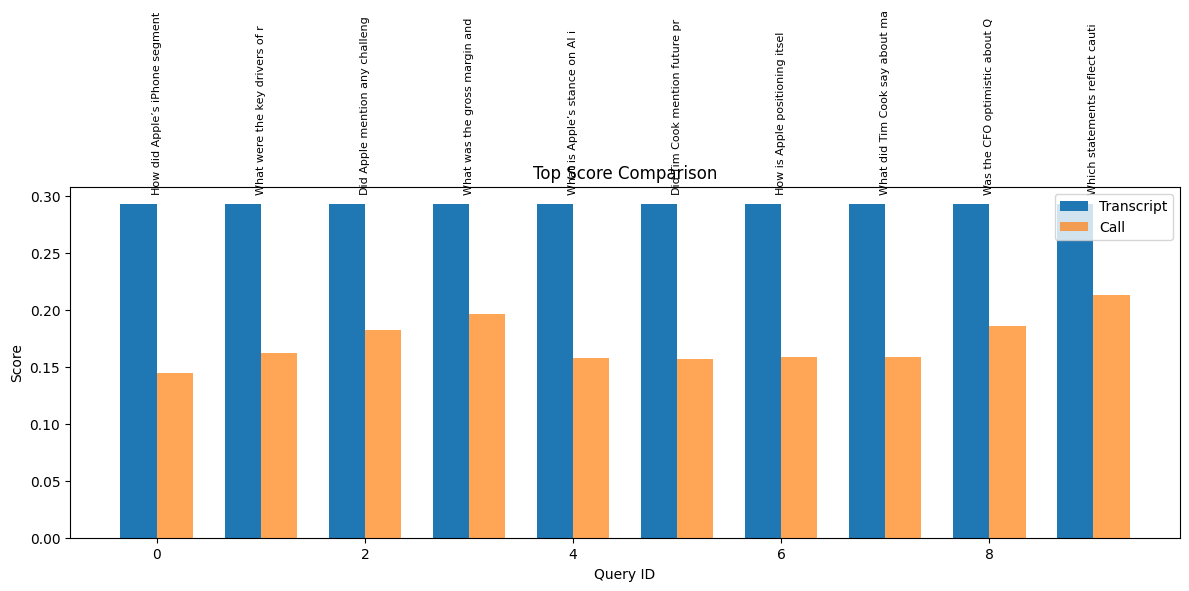

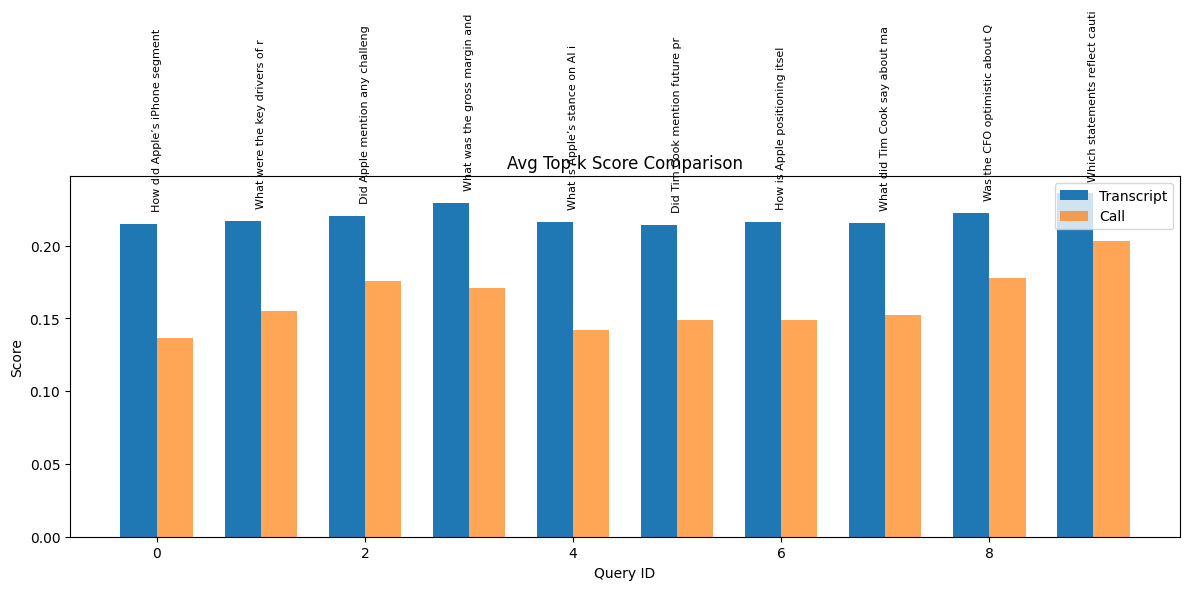

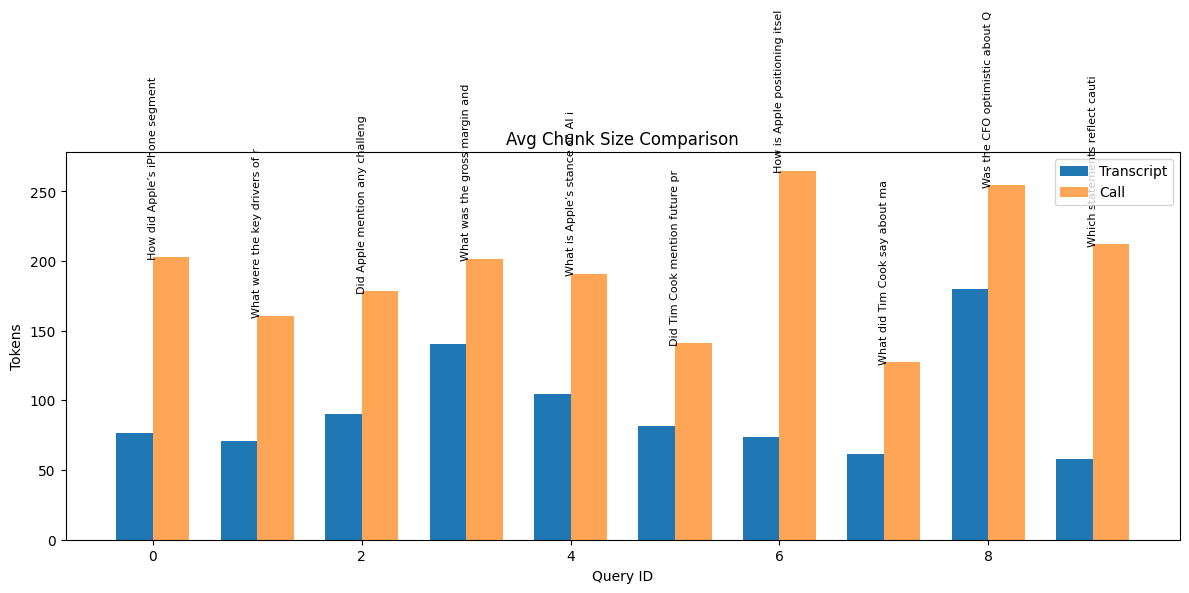

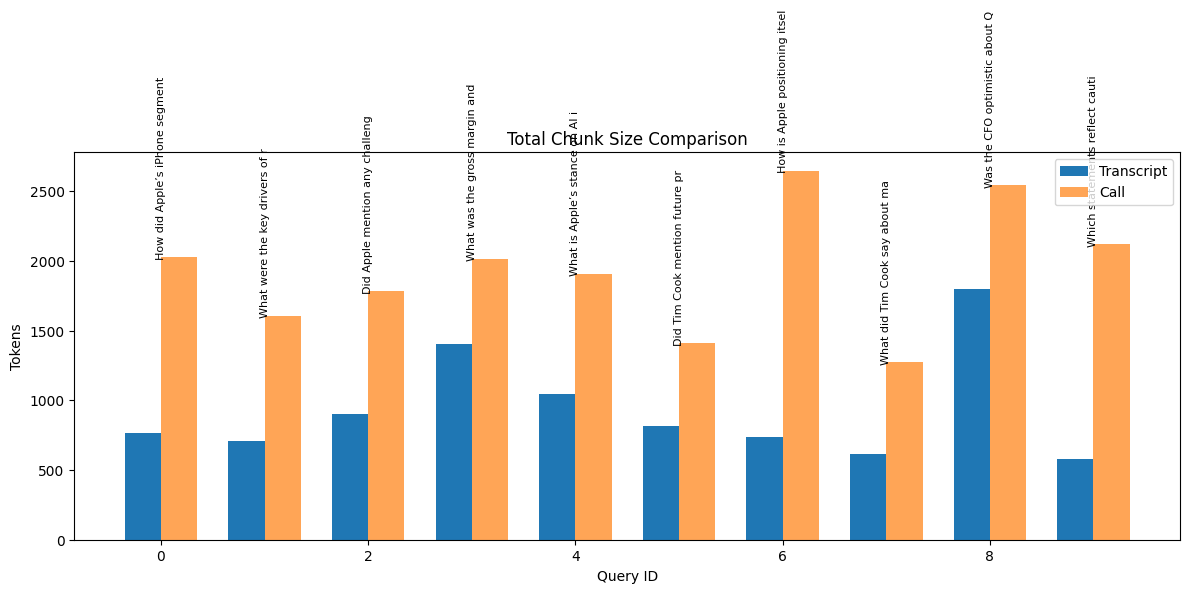

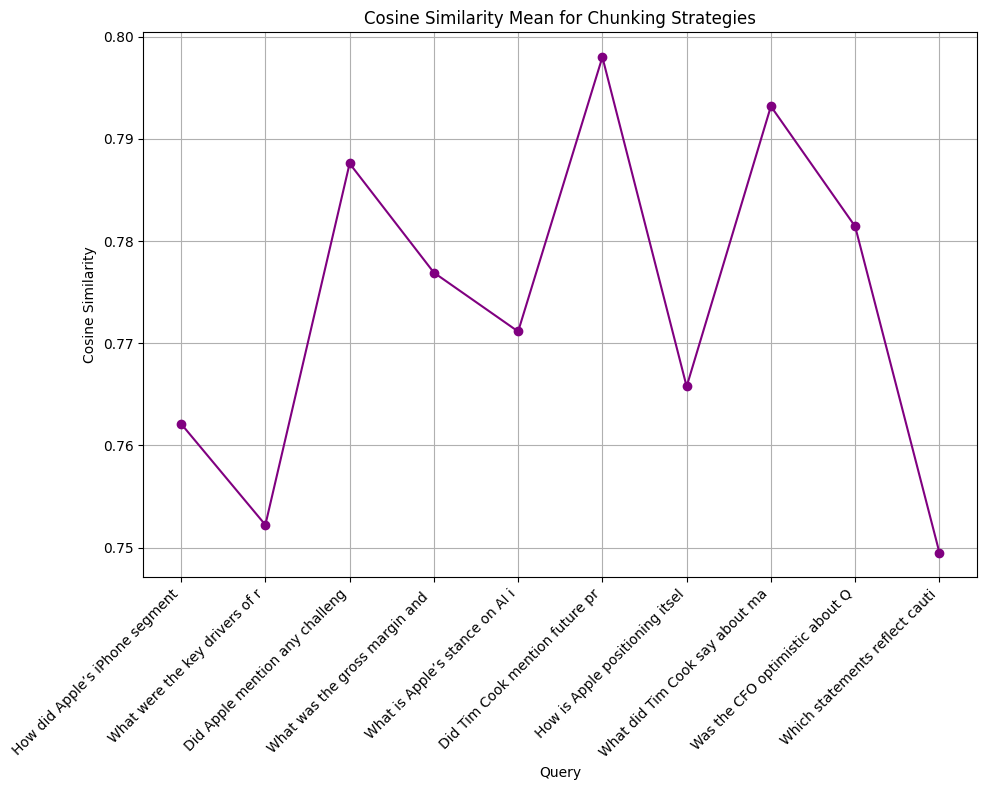

In [38]:
dfLexical =CompareData().createComparisonData(lex_sematicResults)
pltData=PlotData(dfLexical)
pltData.build()
#dfLexical